# Integrated Strategy V3.2: Standardized (Diagnostics)

**Phase 4.8 Refinements**:
1.  **Data**: Using `BTCUSDT_2021_2023_1m_features_standardized.csv` (new relational features + standardized variables).
2.  **Leakage Prevention**: Strict `shift(1)` on HTF signals before broadcasting to 1m execution timeframe.
3.  **Target**: Threshold set to **2%** (`0.02`) to balance signal frequency and profit.
4.  **Backtest**: 1m execution with **0.75% fee** per side.
5.  **Signal Logic**: Long if Expected Return > 2% AND Regime is Bull./
6.  **Visualization**: Trade signals overlay on BTC price.
7.  **Diagnostics**: NaN fill checks and Trade Analysis.

In [8]:
from arch import arch_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Add project root to path
project_root = Path('../').resolve()
sys.path.append(str(project_root))

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Feature-Rich Data

In [9]:
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m_features_standardized.csv'
print(f"Loading data from {data_path}...")

# Load data (parsing dates might take a moment for large files)
df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

print(f"Data Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Loading data from E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m_features_standardized.csv...
Data Shape: (1534847, 61)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'sma_7d', 'sma_30d', 'sma_90d', 'ema_7d', 'ema_21d', 'adx_14d', 'rsi_14d', 'rsi_30d', 'stoch_k_14d', 'stoch_d_14d', 'macd', 'macd_signal', 'macd_diff', 'rsi_14d_regime', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'trend_sma_1d', 'residual_ratio_1d', 'residual_diff_1d', 'trend_sma_7d', 'residual_ratio_7d', 'residual_diff_7d', 'trend_sma_30d', 'residual_ratio_30d', 'residual_diff_30d', 'log_ret', 'volatility_7d', 'volatility_mean_7d', 'volatility_ratio_7d', 'volatility_30d', 'volatility_mean_30d', 'volatility_ratio_30d', 'fd_7d', 'price_dist_sma7_pct', 'price_dist_sma30_pct', 'price_dist_ema7_pct', 'price_dist_ema21_pct', 'ema7_above_sma7', 'ema21_above_sma30', 'ema7_sma7_cross', 'bb_position', 'macd_above_signal', 'macd_cross', 'rsi_oversold', 'rsi_overbought', 'rsi_neutral', 'price_change_1h', 'pri

## 2. Regime Classification (XGBoost)

In [10]:
# select training features
# do not select absolute-value-features (may introduce foward info)
# select standardized indicators, relative metrics (ratios, differences, returns), relationanl features, categorical/binary features
model_features = [
    # Bounded indicators (0-100 or 0-1)
    'rsi_14d', 'rsi_30d',
    'stoch_k_14d', 'stoch_d_14d',
    'adx_14d',
    
    # Relative metrics (ratios, differences, returns)
    'macd', 'macd_signal', 'macd_diff',
    'residual_ratio_1d', 'residual_diff_1d',
    'residual_ratio_7d', 'residual_diff_7d',
    'residual_ratio_30d', 'residual_diff_30d',
    'log_ret',
    'volatility_ratio_7d', 'volatility_ratio_30d',
    'fd_7d',
    
    # New relational features (already normalized or relative)
    'price_dist_sma7_pct', 'price_dist_sma30_pct',
    'price_dist_ema7_pct', 'price_dist_ema21_pct',
    'bb_position',
    'price_change_1h', 'price_change_4h', 'price_change_1d',
    'volume_ratio',
    'atr_normalized',
    'sma7_slope', 'sma30_slope',

    # categorical/binary features
    'rsi_14d_regime',
    'ema7_above_sma7', 'ema21_above_sma30',
    'ema7_sma7_cross', 'macd_cross',
    'macd_above_signal',
    'rsi_oversold', 'rsi_overbought', 'rsi_neutral',
    'strong_trend'
]

# Define Target: 2% return in next 24 hours (1440 minutes)
LOOKAHEAD_MINUTES = 1440  # 24 hours
THRESHOLD = 0.10

df['Future_Return'] = df['Close'].shift(-LOOKAHEAD_MINUTES) / df['Close'] - 1
df['Target'] = (df['Future_Return'] > THRESHOLD).astype(int)

df = df.dropna()

# Train/Test Split
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# Train Regime Classification Model
print(f"Training XGBoost on features: {model_features}")
model_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
model_xgb.fit(train_df[model_features], train_df['Target'])

# Predict
test_df = test_df.copy()
test_df['Predicted_Regime'] = model_xgb.predict(test_df[model_features])
print(classification_report(test_df['Target'], test_df['Predicted_Regime']))

Training XGBoost on features: ['rsi_14d', 'rsi_30d', 'stoch_k_14d', 'stoch_d_14d', 'adx_14d', 'macd', 'macd_signal', 'macd_diff', 'residual_ratio_1d', 'residual_diff_1d', 'residual_ratio_7d', 'residual_diff_7d', 'residual_ratio_30d', 'residual_diff_30d', 'log_ret', 'volatility_ratio_7d', 'volatility_ratio_30d', 'fd_7d', 'price_dist_sma7_pct', 'price_dist_sma30_pct', 'price_dist_ema7_pct', 'price_dist_ema21_pct', 'bb_position', 'price_change_1h', 'price_change_4h', 'price_change_1d', 'volume_ratio', 'atr_normalized', 'sma7_slope', 'sma30_slope', 'rsi_14d_regime', 'ema7_above_sma7', 'ema21_above_sma30', 'ema7_sma7_cross', 'macd_cross', 'macd_above_signal', 'rsi_oversold', 'rsi_overbought', 'rsi_neutral', 'strong_trend']
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    262365
           1       0.00      0.00      0.00      1117

    accuracy                           0.96    263482
   macro avg       0.50      0.48      0.49    263482


In [11]:
# Train GARCH Model for Volatility Filtering
print("Training GARCH(1,1) model on returns...")
# Scale returns by 100 for numerical stability
returns = df['log_ret'] * 100
# Use full data but split for estimation to avoid leakage
train_len = len(train_df)
last_obs_idx = train_df.index[-1]

# Fit GARCH(1,1) using only training data
garch = arch_model(returns, vol='Garch', p=1, q=1, dist='Normal')
res = garch.fit(last_obs=last_obs_idx, disp='off')
print(res.summary())

# Get Conditional Volatility (sigma_t)
# Scale back to original units
df['Predicted_Volatility'] = res.conditional_volatility / 100

# Define Volatility Threshold (e.g., 80th percentile of training volatility)
VOLATILITY_THRESHOLD = df['Predicted_Volatility'].iloc[:train_len].quantile(0.80)
print(f"Volatility Threshold: {VOLATILITY_THRESHOLD}")


Training GARCH(1,1) model on returns...


c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.677e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:           -6.31780e+06
Distribution:                  Normal   AIC:                       1.26356e+07
Method:            Maximum Likelihood   BIC:                       1.26357e+07
                                        No. Observations:              1053925
Date:                Sat, Dec 13 2025   Df Residuals:                  1053924
Time:                        14:18:39   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0503      0.117     -0.429      0.668 [ -0.280,  0.18

In [12]:
# Train GARCH Model for Volatility Filtering
print("Training GARCH(1,1) model on returns...")
# Scale returns by 100 for numerical stability
returns = df['log_ret'] * 100
# Use full data but split for estimation to avoid leakage
train_len = len(train_df)
last_obs_idx = train_df.index[-1]

# Fit GARCH(1,1) using only training data
garch = arch_model(returns, vol='Garch', p=1, q=1, dist='Normal')
res = garch.fit(last_obs=last_obs_idx, disp='off')
print(res.summary())

# Get Conditional Volatility (sigma_t)
# Scale back to original units
df['Predicted_Volatility'] = res.conditional_volatility / 100

# Define Volatility Threshold (e.g., 80th percentile of training volatility)
VOLATILITY_THRESHOLD = df['Predicted_Volatility'].iloc[:train_len].quantile(0.80)
print(f"Volatility Threshold: {VOLATILITY_THRESHOLD}")


Training GARCH(1,1) model on returns...


c:\Users\watte\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.677e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:           -6.31780e+06
Distribution:                  Normal   AIC:                       1.26356e+07
Method:            Maximum Likelihood   BIC:                       1.26357e+07
                                        No. Observations:              1053925
Date:                Sat, Dec 13 2025   Df Residuals:                  1053924
Time:                        14:18:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0503      0.117     -0.429      0.668 [ -0.280,  0.18

## 3. Hybrid Forecasting (Prophet + ARIMA)

In [13]:
# Resample to 1H for Forecasting
df_1h = df.resample('1H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

# Align with Test Period
start_date = test_df.index[0]
df_forecast = df_1h[df_1h.index >= start_date].copy()

# Train on PREVIOUS data (No leakage)
train_prophet = df_1h[df_1h.index < start_date].reset_index()[['timestamp', 'Close']].rename(columns={'timestamp': 'ds', 'Close': 'y'})

print("Training Prophet...")
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(df_forecast), freq='H')
forecast_prophet = model_prophet.predict(future)
trend_pred = forecast_prophet.iloc[-len(df_forecast):]['yhat'].values

residuals = train_prophet['y'] - forecast_prophet.iloc[:-len(df_forecast)]['yhat']
print("Training ARIMA...")
model_arima = ARIMA(residuals, order=(5,0,1)).fit()
resid_pred = model_arima.forecast(steps=len(df_forecast))

df_forecast['Forecast'] = trend_pred + resid_pred.values

# Expected Return (Next Forecast vs Current Close)
df_forecast['Next_Forecast'] = df_forecast['Forecast'].shift(-1)
df_forecast['Expected_Return'] = df_forecast['Next_Forecast'] / df_forecast['Close'] - 1

Training Prophet...


14:18:44 - cmdstanpy - INFO - Chain [1] start processing
14:18:47 - cmdstanpy - INFO - Chain [1] done processing


Training ARIMA...


## 4. Signal Integration (Strict Leakage Prevention)

In [14]:
# 1. Prepare HTF/1m Signals
# Shift(1) ensures we use the signal from the COMPLETED bar
regime_signal = test_df[['Predicted_Regime']].shift(1)
volatility_signal = df.loc[test_df.index, ['Predicted_Volatility']].shift(1)
forecast_signal = df_forecast[['Expected_Return']].shift(1)

# 2. Broadcast to 1m Execution Timeframe
execution_df = df[df.index >= start_date].copy()

# Drop Predicted_Volatility from execution_df to avoid column conflict
if 'Predicted_Volatility' in execution_df.columns:
    execution_df = execution_df.drop('Predicted_Volatility', axis=1)

execution_df = execution_df.join(regime_signal.resample('1min').ffill().reindex(execution_df.index, method='ffill'))
execution_df = execution_df.join(volatility_signal.resample('1min').ffill().reindex(execution_df.index, method='ffill'))
execution_df = execution_df.join(forecast_signal.resample('1min').ffill().reindex(execution_df.index, method='ffill'))

# Fill NaNs
execution_df['Predicted_Regime'] = execution_df['Predicted_Regime'].fillna(0)
execution_df['Predicted_Volatility'] = execution_df['Predicted_Volatility'].fillna(method='bfill') # Fill backward for start
execution_df['Expected_Return'] = execution_df['Expected_Return'].fillna(0)

# 3. Generate Trade Signals for 3 Scenarios
SIGNAL_THRESHOLD = 0.02
# VOLATILITY_THRESHOLD is defined in GARCH cell

# Scenario 1: ARIMA Only
execution_df['Signal_ARIMA'] = np.where(
    (execution_df['Expected_Return'] > SIGNAL_THRESHOLD),
    1, 0
)

# Scenario 2: GARCH Only (ARIMA + GARCH Filter)
execution_df['Signal_GARCH'] = np.where(
    (execution_df['Expected_Return'] > SIGNAL_THRESHOLD) & 
    (execution_df['Predicted_Volatility'] < VOLATILITY_THRESHOLD),
    1, 0
)

# Scenario 3: All 3 Models (ARIMA + Regime + GARCH)
execution_df['Signal_All'] = np.where(
    (execution_df['Expected_Return'] > SIGNAL_THRESHOLD) & 
    (execution_df['Predicted_Regime'] == 1) & 
    (execution_df['Predicted_Volatility'] < VOLATILITY_THRESHOLD),
    1, 0
)

print("Signal Distribution (All 3):")
print(execution_df['Signal_All'].value_counts())


Signal Distribution (All 3):
Signal_All
0    263482
Name: count, dtype: int64


C:\Users\watte\AppData\Local\Temp\ipykernel_49732\2604660263.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  execution_df['Predicted_Volatility'] = execution_df['Predicted_Volatility'].fillna(method='bfill') # Fill backward for start


## 5. Realistic Backtest

In [15]:
def run_backtest(signal_col, name):
    print(f"\n--- Backtest Scenario: {name} ---")
    # Basic Vectorized Backtest
    # Assume we enter on Signal=1, hold for 1 bar (or until exit?)
    # The previous code implied: Signal 1 -> Long. 0 -> Neutral.
    # Let's stick to that.
    
    # Calculate Strategy Returns
    # If Signal is 1 at t, we buy at Close of t (or Open of t+1?)
    # Since we shifted signals, 'Signal' at t is based on info at t-1.
    # So we can trade at Open of t or Close of t.
    # 'log_ret' in df is ln(Close_t / Close_{t-1}).
    # If Signal[t] is 1, we want the return of t.
    
    # Commission & Slippage
    COMMISSION = 0.00075
    SLIPPAGE = 0.0001
    COST = COMMISSION + SLIPPAGE
    
    # Strategy Return = Signal * Return - Costs
    # Cost applies on Entry and Exit. 
    # Approximation: Cost on every trade change? 
    # Or just Cost * 2 if we hold? 
    # Simple approximation: If Signal=1, we get the return. 
    # We pay cost when we enter (0->1) and exit (1->0).
    
    positions = execution_df[signal_col]
    trades = positions.diff().abs()
    
    # Returns
    # Note: execution_df['log_ret'] is return at t.
    strategy_returns = positions * execution_df['log_ret'] - (trades * COST)
    
    # Cumulative
    cumulative_returns = (1 + strategy_returns).cumprod()
    buy_hold = (1 + execution_df['log_ret']).cumprod()
    
    # Metrics
    net_return = cumulative_returns.iloc[-1] - 1
    bh_return = buy_hold.iloc[-1] - 1
    
    # Sharpe (Annualized)
    # 1m data -> 525600 mins/year
    sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(525600) if strategy_returns.std() > 0 else 0
    
    # Max Drawdown
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_dd = drawdown.min()
    
    print(f"Strategy Net Return: {net_return*100:.2f}%")
    print(f"Buy & Hold Return: {bh_return*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_dd*100:.2f}%")

run_backtest('Signal_All', 'All 3 Models (ARIMA + Regime + GARCH)')
run_backtest('Signal_ARIMA', 'ARIMA Only')
run_backtest('Signal_GARCH', 'GARCH Only (ARIMA + GARCH)')



--- Backtest Scenario: All 3 Models (ARIMA + Regime + GARCH) ---
Strategy Net Return: 0.00%
Buy & Hold Return: -100.00%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%

--- Backtest Scenario: ARIMA Only ---
Strategy Net Return: -100.00%
Buy & Hold Return: -100.00%
Sharpe Ratio: 2.08
Max Drawdown: -100.34%

--- Backtest Scenario: GARCH Only (ARIMA + GARCH) ---
Strategy Net Return: 0.00%
Buy & Hold Return: -100.00%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%


## 6. Time-Series Only Strategy (No Regime Filter)

Running Time-Series Only Strategy (No Regime Filter)...
Signal Threshold: 2.0%
Signal Distribution (Time-Series Only):
Signal_TS
1    154763
0    108719
Name: count, dtype: int64
Time-Series Strategy Net Return: 44468.02%
Sharpe Ratio: 2.09
Max Drawdown: -28451.24%


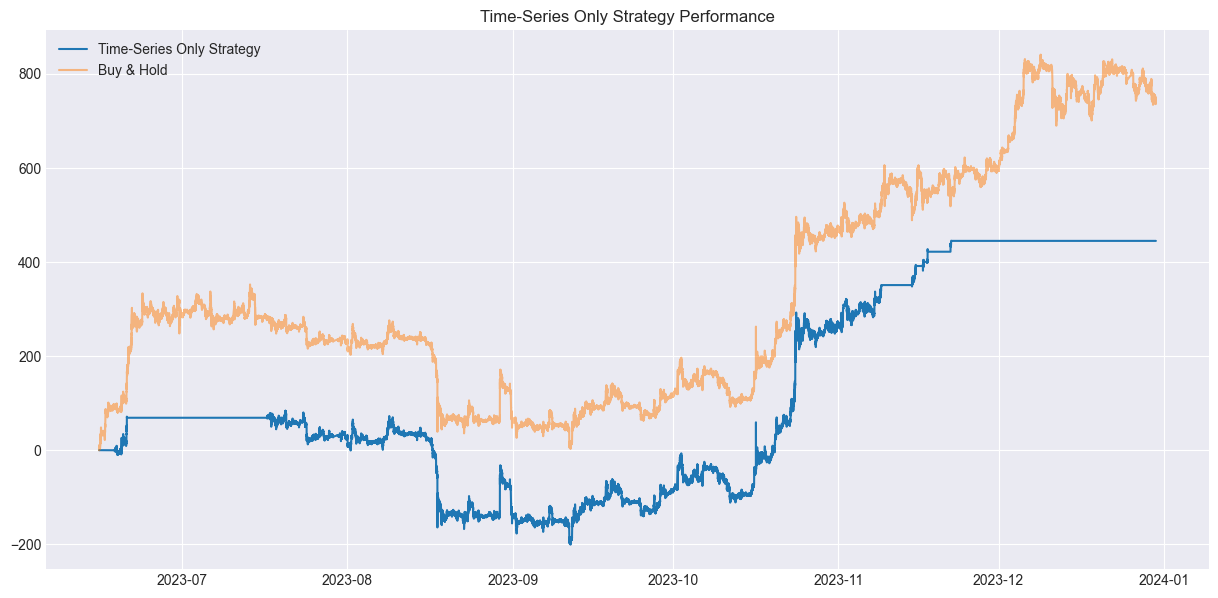

In [16]:
# 6. Time-Series Only Strategy
print("Running Time-Series Only Strategy (No Regime Filter)...")

# Use the same forecast data but ignore the regime signal
# Signal: Long if Expected_Return > 2%
SIGNAL_THRESHOLD = 0.02
print(f"Signal Threshold: {SIGNAL_THRESHOLD*100}%")

execution_df['Signal_TS'] = np.where(
    execution_df['Expected_Return'] > SIGNAL_THRESHOLD,
    1,
    0
)

print("Signal Distribution (Time-Series Only):")
print(execution_df['Signal_TS'].value_counts())

# Backtest
execution_df['Strategy_Return_TS'] = execution_df['Signal_TS'].shift(1) * execution_df['log_ret']

# Apply Fees (0.75% per side)
trades_ts = execution_df['Signal_TS'].diff().abs().fillna(0)
FEE = 0.0075
execution_df['Cost_TS'] = trades_ts * FEE
execution_df['Net_Return_TS'] = execution_df['Strategy_Return_TS'] - execution_df['Cost_TS']

# Performance Metrics
cumulative_return_ts = execution_df['Net_Return_TS'].cumsum()
total_return_ts = cumulative_return_ts.iloc[-1]
sharpe_ratio_ts = execution_df['Net_Return_TS'].mean() / execution_df['Net_Return_TS'].std() * np.sqrt(365*24*60)

# Max Drawdown
rolling_max_ts = cumulative_return_ts.cummax()
drawdown_ts = cumulative_return_ts - rolling_max_ts
max_drawdown_ts = drawdown_ts.min()

print(f"Time-Series Strategy Net Return: {total_return_ts*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_ts:.2f}")
print(f"Max Drawdown: {max_drawdown_ts*100:.2f}%")

# Plot
plt.figure(figsize=(15, 7))
plt.plot(cumulative_return_ts.index, cumulative_return_ts, label='Time-Series Only Strategy')
plt.plot(execution_df.index, execution_df['log_ret'].cumsum(), label='Buy & Hold', alpha=0.5)
plt.title('Time-Series Only Strategy Performance')
plt.legend()
plt.show()

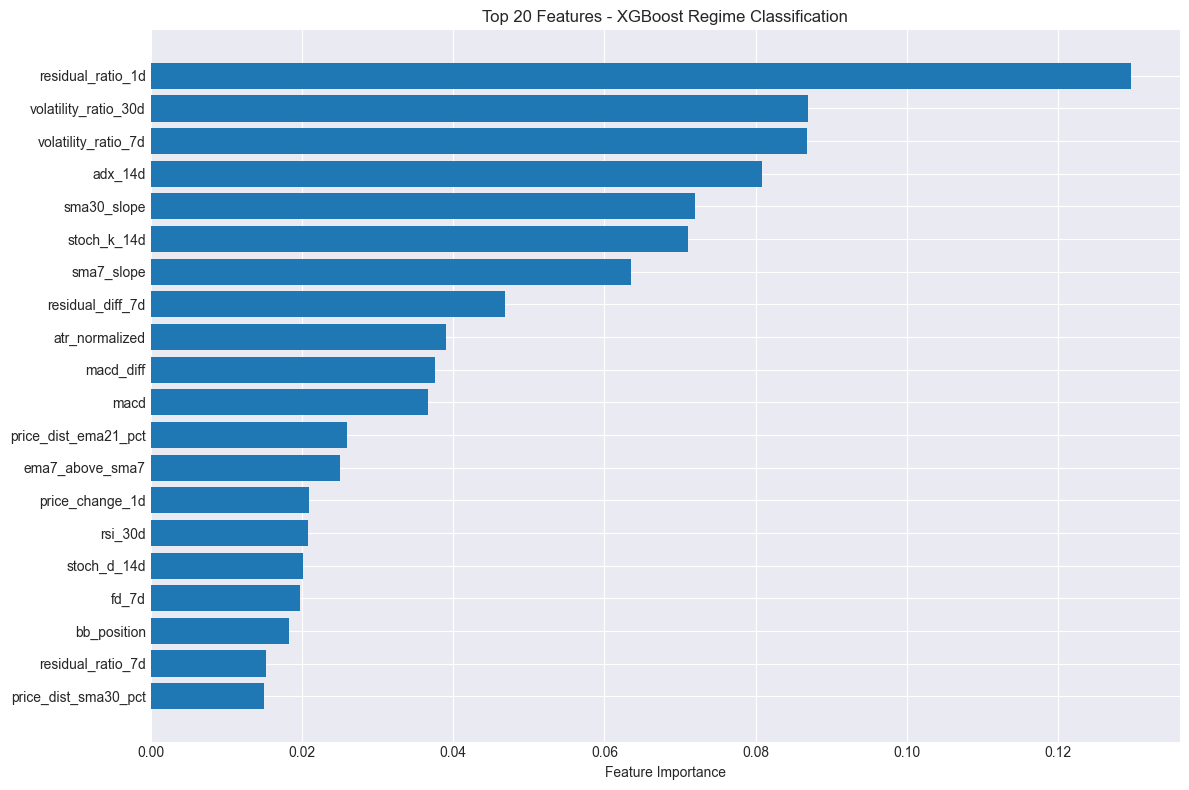

Top 10 Features:
                 feature  importance
8      residual_ratio_1d    0.129598
16  volatility_ratio_30d    0.086902
15   volatility_ratio_7d    0.086760
4                adx_14d    0.080848
29           sma30_slope    0.071907
2            stoch_k_14d    0.071094
28            sma7_slope    0.063566
11      residual_diff_7d    0.046864
27        atr_normalized    0.039080
7              macd_diff    0.037645


In [17]:
# Feature Importance
# Get feature importances
importances = model_xgb.feature_importances_
feature_names = model_features

# Create DataFrame
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'][:20][::-1], feature_importance_df['importance'][:20][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features - XGBoost Regime Classification')
plt.tight_layout()
plt.show()

print("Top 10 Features:")
print(feature_importance_df.head(10))


In [18]:
print(df.head())

                         Open      High       Low     Close      Volume  \
timestamp                                                                 
2021-05-31 10:02:00  36010.01  36211.00  35958.87  36211.00  172.820893   
2021-05-31 10:03:00  36210.08  36349.38  36155.17  36282.43  292.291756   
2021-05-31 10:04:00  36283.92  36731.53  36223.58  36552.42  873.084034   
2021-05-31 10:05:00  36552.42  36557.02  36458.33  36510.37  259.925727   
2021-05-31 10:06:00  36510.37  36547.59  36456.58  36506.88   95.624098   

                           sma_7d       sma_30d       sma_90d        ema_7d  \
timestamp                                                                     
2021-05-31 10:02:00  37142.866236  46962.456593  53003.926760  36823.868263   
2021-05-31 10:03:00  37142.857848  46961.965385  53003.829094  36823.760845   
2021-05-31 10:04:00  37142.874261  46961.482384  53003.733125  36823.707013   
2021-05-31 10:05:00  37142.889089  46960.998005  53003.636431  36823.644849   
